In [11]:
# First code block is the import libraries  
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

pd.reset_option('^display.', silent=True)

In [3]:
def data_splitting(df: pd.DataFrame):
    df_new = df
        
    # handling the seat of passengers 
    df_new[['Cabin_deck','Cabin_num','Cabin_side']] = df['Cabin'].str.split('/',expand=True)

    # handling spending of each passengers : RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
    df_new[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]] = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].fillna(0)
    df_new.loc[:, ['Total_spending']] = df_new['RoomService'] + df_new['FoodCourt'] + df_new['ShoppingMall'] + df_new['Spa'] + df_new['VRDeck']

    if 'Transported' in df_new.columns:
        df_processedData = df_new[
            [   'PassengerId', 'HomePlanet', 'CryoSleep',
                'Cabin_deck', 'Cabin_num', 'Cabin_side', 
                'Destination', 'Age',
                'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_spending',
                'Name',
                'Transported'
            ]
        ]
    else:
        df_processedData = df_new[
            [   'PassengerId', 'HomePlanet', 'CryoSleep',
                'Cabin_deck', 'Cabin_num', 'Cabin_side', 
                'Destination', 'Age',
                'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_spending',
                'Name'
            ]
        ]
    
    return df_processedData

In [4]:
def categorize_spending(df: pd.DataFrame):
    df_new = df

    mean_value = df_new['Total_spending'].mean()
    std_value = df_new['Total_spending'].std()

    thresholds = [
        float('-inf'), 
        mean_value - 0.5 * std_value,
        mean_value + 0.5 * std_value, 
        float('inf')
    ]

    df_new['spending_Categ'] = pd.cut(df['Total_spending'], bins=thresholds, labels=['Low', 'Medium', 'High'])

    return df_new

In [5]:
def dropCols(df: pd.DataFrame):

    if 'Transported' in df.columns:
        df_new = df[
            [   'HomePlanet', 'CryoSleep',
                'Cabin_deck', 'Cabin_side', 
                'Age',
                'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                'spending_Categ',
                'Transported'
            ]
        ]
    else:
        df_new = df[
            [   'HomePlanet', 'CryoSleep',
                'Cabin_deck', 'Cabin_side',
                'Age',
                'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                'spending_Categ'
            ]
        ]
    return df_new

In [6]:
def fill_null(df: pd.DataFrame):
    # fill null record: HomePlanet, CryoSleep, Cabin_deck, Cabin_side, Age
    df_new = df
    df_new['Age'] = df['Age'].fillna(int(df['Age'].mean()))

    # fill na value of CryoSleep
    mapping = {
        'High': False,
        'Medium': False,
        'Low': True
    }

    # Fill the missing values in 'sleep' column based on 'categ' labels
    df_new['CryoSleep'] = df.apply(lambda row: mapping[row['spending_Categ']] if pd.isna(row['CryoSleep']) else row['CryoSleep'], axis=1)


    return df_new

In [7]:
def oneHot(df: pd.DataFrame):
    # apply one-hot encoding to non-numberic data
    one_hot= pd.DataFrame()
    df['CryoSleep'] = df['CryoSleep'].astype(bool)
    one_hot = pd.get_dummies(df)

    # reorder the dataframe
    if 'Transported' in df.columns:
        one_hot = one_hot[['CryoSleep', 
            'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 
            'Cabin_deck_A', 'Cabin_deck_B', 'Cabin_deck_C', 
            'Cabin_deck_D', 'Cabin_deck_E', 'Cabin_deck_F',
            'Cabin_deck_G', 'Cabin_deck_T', 
            'Cabin_side_P', 'Cabin_side_S',
            'Age',
            'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
            'spending_Categ_Low', 'spending_Categ_Medium', 'spending_Categ_High',
            'Transported'
        ]]
    else:
        one_hot = one_hot[['CryoSleep', 
            'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 
            'Cabin_deck_A', 'Cabin_deck_B', 'Cabin_deck_C', 
            'Cabin_deck_D', 'Cabin_deck_E', 'Cabin_deck_F',
            'Cabin_deck_G', 'Cabin_deck_T', 
            'Cabin_side_P', 'Cabin_side_S',
            'Age',
            'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
            'spending_Categ_Low', 'spending_Categ_Medium', 'spending_Categ_High'
        ]]

    return one_hot

In [25]:
# normalize the data

def normalize(df):
    # age = df['Age']
    floatCols = df.iloc[:, 4:10]

    scaler = MinMaxScaler()
    # age = scaler.fit_transform(pd.DataFrame(age))
    temp = scaler.fit_transform(floatCols)

    normalized = df
    # normalized['Age'] = pd.DataFrame(age)
    normalized.iloc[:, 4:10] = temp

    return normalized

In [29]:
def dataProcess(df: pd.DataFrame):
    
    df_new = data_splitting(df)
    df_new = categorize_spending(df_new)
    df_new = dropCols(df_new)
    df_new = fill_null(df_new)
    df_new = normalize(df_new)
    df_new = oneHot(df_new)

    return df_new

In [30]:
rawTrain_dataPath = '../spaceship-titanic_rawData/spaceship_train.csv'
rawTest_dataPath = '../spaceship-titanic_rawData/spaceship_test.csv'


df_public = pd.read_csv(rawTrain_dataPath)
df_private = pd.read_csv(rawTest_dataPath)

pre_train = dataProcess(df_public)
pre_test = dataProcess(df_private)



In [21]:
ind = 0
for col in pre_train.columns:
    print(ind, col)
    ind += 1

0 HomePlanet
1 CryoSleep
2 Cabin_deck
3 Cabin_side
4 Age
5 RoomService
6 FoodCourt
7 ShoppingMall
8 Spa
9 VRDeck
10 spending_Categ
11 Transported


In [31]:
pre_train

,CryoSleep,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,...,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,spending_Categ_Low,spending_Categ_Medium,spending_Categ_High,Transported
0,False,False,True,False,False,True,False,False,False,False,...,0.493671,0.000000,0.000000,0.000000,0.000000,0.000000,True,False,False,False
1,False,True,False,False,False,False,False,False,False,True,...,0.303797,0.007608,0.000302,0.001064,0.024500,0.001823,False,True,False,True
2,False,False,True,False,True,False,False,False,False,False,...,0.734177,0.003001,0.119948,0.000000,0.299670,0.002030,False,False,True,False
3,False,False,True,False,True,False,False,False,False,False,...,0.417722,0.000000,0.043035,0.015793,0.148563,0.007997,False,False,True,False
4,False,True,False,False,False,False,False,False,False,True,...,0.202532,0.021149,0.002348,0.006428,0.025214,0.000083,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,False,True,False,True,False,False,False,False,False,...,0.518987,0.000000,0.228726,0.000000,0.073322,0.003066,False,False,True,False
8689,True,True,False,False,False,False,False,False,False,False,...,0.227848,0.000000,0.000000,0.000000,0.000000,0.000000,True,False,False,False
8690,False,True,False,False,False,False,False,False,False,False,...,0.329114,0.000000,0.000000,0.079687,0.000045,0.000000,False,True,False,True
8691,False,False,True,False,False,False,False,False,True,False,...,0.405063,0.000000,0.035186,0.000000,0.015753,0.134049,False,False,True,False


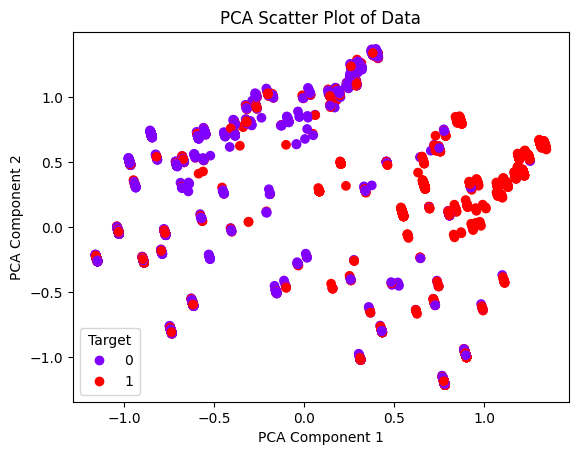

In [32]:
normalized_x, y_public= pre_train.drop('Transported', axis = 1), pre_train['Transported']

# Create a PCA object with 2 components
pca_2 = PCA(n_components=2)

# Fit the PCA model to the data
pca_2.fit(normalized_x)

# Transform the data into the new 2D space
X_pca = pca_2.transform(normalized_x)

# Plot the scatter graph
fig, ax = plt.subplots()
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c = y_public, cmap='rainbow')

# Add a legend to the plot
legend = ax.legend(*scatter.legend_elements(), loc="lower left", title="Target")

ax.set_title("PCA Scatter Plot of Data")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")

plt.show()

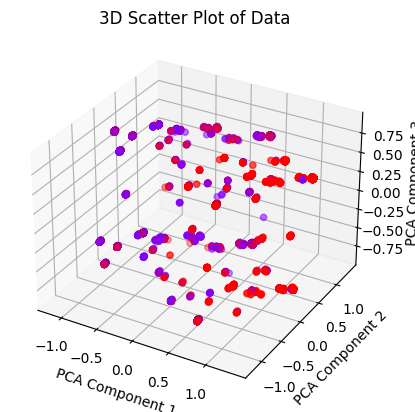

In [35]:
# Create a PCA object with 3 components
pca_3 = PCA(n_components=3)

pca_3.fit(normalized_x)

# Transform the data into the new 3D space
X_pca = pca_3.transform(normalized_x)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = y_public, cmap='rainbow')

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Scatter Plot of Data')

plt.show()

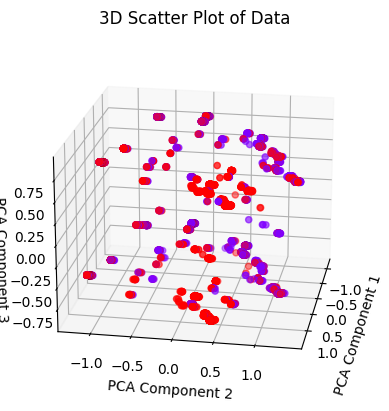

In [41]:
# Create a PCA object with 3 components
pca_3 = PCA(n_components=3)

pca_3.fit(normalized_x)

# Transform the data into the new 3D space
X_pca = pca_3.transform(normalized_x)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = y_public, cmap='rainbow')

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.set_title('3D Scatter Plot of Data')

# Set the view angle
ax.view_init(elev=20, azim=10)  # Adjust the elevation and azimuth angles as desired

plt.show()

In [13]:
# Export result
filename = str(os.path.basename(globals()['__vsc_ipynb_file__'])).replace('.ipynb', '')

train_export = '../preprocess_train_dataset/' + filename + '_train.csv'
test_export = '../preprocess_test_dataset/' + filename + '_test.csv'

pre_train.to_csv(train_export, sep=',', encoding='utf-8', index=False)
pre_test.to_csv(test_export, sep=',', encoding='utf-8', index=False)